In [9]:
from research.interest_rates.scripts.backtesting import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import yfinance as yf

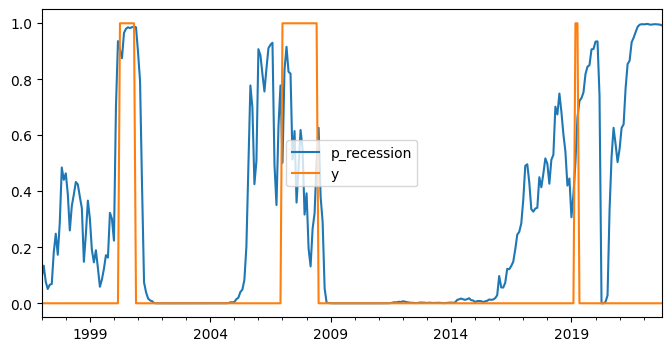

In [3]:
# OOS probability series
oos = pd.read_csv("../../../data/processed/recession_prob_12m_oos_multivar.csv",
                  index_col=0, parse_dates=True).rename(columns={"phat":"p_recession","y":"y"})
oos = oos.asfreq("ME")
oos.plot(figsize=(8,4))
plt.show()

In [5]:
# download prices and compute monthly returns
start_date = oos.index[0]
tickers = ["SPY", "VFITX"]
px = yf.download(tickers, start=start_date, auto_adjust=True, progress=False)["Close"]
px = px.resample("ME").last()

ret = px.pct_change().dropna()
ret.rename(columns={'SPY': 'ret_eq', 'VFITX': 'ret_bond'}, inplace=True)
ret

Ticker,ret_eq,ret_bond
Date,,
1997-02-28,0.009566,0.000984
1997-03-31,-0.044122,-0.013035
1997-04-30,0.062604,0.016122
1997-05-31,0.063206,0.008343
1997-06-30,0.041103,0.010032
...,...,...
2025-06-30,0.051386,0.012433
2025-07-31,0.023032,-0.004689
2025-08-31,0.020520,0.015434


In [6]:
df = oos.join(ret, how="inner").dropna()
df

,p_recession,y,ret_eq,ret_bond
1997-02-28,0.134124,0,0.009566,0.000984
1997-03-31,0.077201,0,-0.044122,-0.013035
1997-04-30,0.051048,0,0.062604,0.016122
1997-05-31,0.066194,0,0.063206,0.008343
1997-06-30,0.068870,0,0.041103,0.010032
...,...,...,...,...
2022-06-30,0.996404,0,-0.082460,-0.008271
2022-07-31,0.996713,0,0.092087,0.019217
2022-08-31,0.996134,0,-0.040802,-0.029086
2022-09-30,0.995388,0,-0.092446,-0.032554


,lambda_prob,p_halflife,up,down,confirm,mom_lb,cash_filter,vol_target,annual_return,annual_vol,sharpe,sortino,max_drawdown,max_dd_years,turnover
i,,,,,,,,,,,,,,,
0,0.5,3,0.6,0.40,2,2,True,None,0.096554,0.120172,0.830265,1.364991,-0.414175,3.500000,0.025442
1,0.5,3,0.6,0.40,2,3,True,None,0.096248,0.120154,0.828025,1.360473,-0.414175,3.500000,0.025442
2,0.5,3,0.6,0.40,2,4,True,None,0.094585,0.120206,0.814989,1.337393,-0.414175,3.500000,0.025442
3,0.5,3,0.6,0.40,2,5,True,None,0.093566,0.120290,0.806700,1.323766,-0.414175,3.500000,0.025442
4,0.5,3,0.6,0.40,2,6,True,None,0.093579,0.120296,0.806762,1.323219,-0.414175,3.500000,0.025442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1.0,3,1.0,0.55,2,2,True,None,0.088700,0.114132,0.804245,1.373047,-0.340931,2.666667,0.021664
1976,1.0,3,1.0,0.55,2,3,True,None,0.088700,0.114132,0.804245,1.373047,-0.340931,2.666667,0.021664
1977,1.0,3,1.0,0.55,2,4,True,None,0.088700,0.114132,0.804245,1.373047,-0.340931,2.666667,0.021664


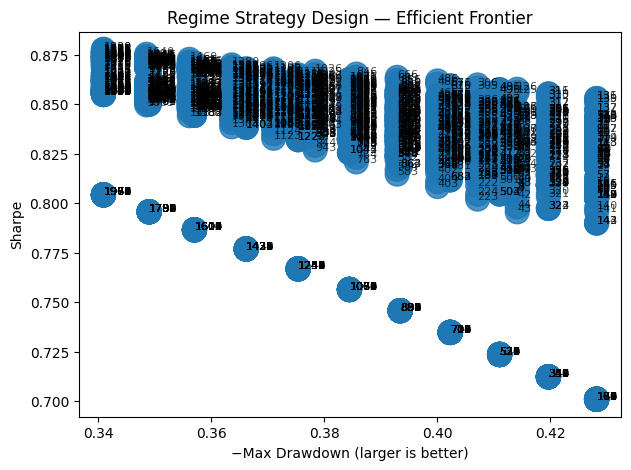

In [22]:
# Compare a grid to see a "frontier"
# grid = [
#     RegimeConfig(lambda_prob=0.5, up=0.6, down=0.5, confirm=2, use_cash_filter=False),
#     RegimeConfig(lambda_prob=0.7, up=0.6, down=0.5, confirm=2, use_cash_filter=True),
#     RegimeConfig(lambda_prob=0.8, up=0.65, down=0.55, confirm=2, use_cash_filter=True),
#     RegimeConfig(lambda_prob=0.7, up=0.6, down=0.5, confirm=2, use_cash_filter=True, vol_target_ann=0.10),
# ]

grid = []

for i in np.linspace(0.5, 1.0, 11):
    for j in np.arange(0.6, 1.05, 0.05):
        for k in np.arange(0.4, 0.6, 0.05):
            for m in [2, 3, 4, 5, 6]:
                grid.append(
                    RegimeConfig(lambda_prob=i, up=j, down=k, confirm=2, mom_lookback_m=m, use_cash_filter=True)
                )

df_params = run_param_grid(df, grid)
display(df_params)
plot_frontier(df_params, "Regime Strategy Design — Efficient Frontier")


In [23]:
# Minimal example config
cfg = RegimeConfig(
    lambda_prob=1.0,       # blend: 70% probability, 30% hysteresis state
    p_ewma_halflife=3,     # smooth probabilities
    up=0.95, down=0.55,      # confirmation band
    confirm=2,             # need 2 consecutive months
    mom_lookback_m=3,      # 6m bond momentum
    use_cash_filter=True,  # divert to cash if risk-off & bond momentum<0
    vol_target_ann=None    # set e.g. 0.10 to enable portfolio vol targeting
)

res = build_portfolio_returns(df, cfg)
metrics = evaluate(res["r_port"], res["w_bond"])
print(metrics)

{'annual_return': np.float64(0.09493872919157864), 'annual_vol': np.float64(0.11307397219785487), 'sharpe': np.float64(0.861628709914048), 'sortino': np.float64(1.4798823911052723), 'max_drawdown': -0.34093097919814985, 'max_dd_years': 2.6666666666666665, 'turnover': np.float64(0.021663620790684533)}


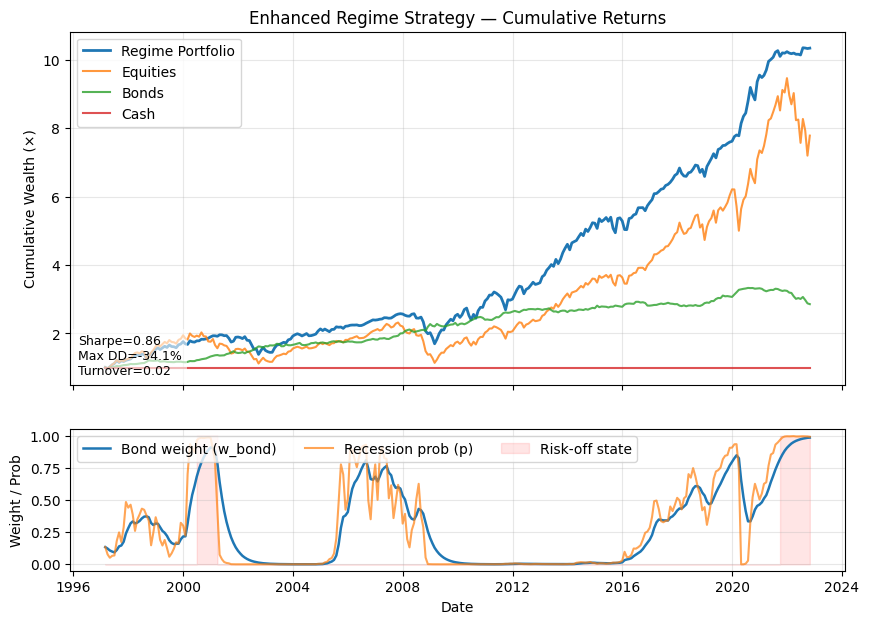

In [29]:
def plot_cumret_with_weights(res, df, title_top="Enhanced Regime Strategy — Cumulative Returns"):
    """
    Top: cumulative wealth of the regime portfolio vs sleeves.
    Bottom: bond weight (w_bond) with recession probability & state overlay (optional).
    Expects:
      res["r_port"], res["w_bond"], res["state"]
      df["ret_eq"], df["ret_bond"], optional df["ret_cash"], df["p_recession"]
    """
    # wealth
    port = (1 + res["r_port"].fillna(0)).cumprod()
    eq   = (1 + df["ret_eq"].fillna(0)).cumprod()
    bond = (1 + df["ret_bond"].fillna(0)).cumprod()
    cash = (1 + df.get("ret_cash", df["ret_bond"]*0)).cumprod()

    w = res["w_bond"].clip(0,1)
    state = res.get("state", w*0)  # 0 risk-on, 1 risk-off if present
    p = df.get("p_recession", None)

    fig = plt.figure(figsize=(10,7))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1.2], hspace=0.18)

    # --- Top: cumulative returns
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(port, label="Regime Portfolio", linewidth=2.0)
    ax1.plot(eq,   label="Equities", alpha=0.8)
    ax1.plot(bond, label="Bonds", alpha=0.8)
    ax1.plot(cash, label="Cash", alpha=0.8)
    ax1.set_title(title_top)
    ax1.set_ylabel("Cumulative Wealth (×)")
    ax1.grid(alpha=0.3)
    ax1.legend(loc="upper left")

    # Optional: quick on-plot stats
    from math import sqrt
    ann_vol = res["r_port"].std(ddof=1)*sqrt(12)
    ann_ret = (port.iloc[-1]**(12/len(port)) - 1) if len(port) > 12 else float("nan")
    sharpe  = ann_ret/ann_vol if ann_vol>0 else float("nan")
    m = evaluate(res["r_port"], res["w_bond"])
    ax1.text(0.01, 0.02,
             f"Sharpe={m['sharpe']:.2f}\nMax DD={m['max_drawdown']:.1%}\nTurnover={m['turnover']:.2f}",
             transform=ax1.transAxes, va="bottom", ha="left",
             fontsize=9, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    # --- Bottom: bond weight (and optional probability / state)
    ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
    ax2.plot(w, label="Bond weight (w_bond)", linewidth=1.8)
    if p is not None:
        ax2.plot(p.clip(0,1), label="Recession prob (p)", alpha=0.7)
    if "state" in res:
        ax2.fill_between(w.index, 0, state, step="pre", alpha=0.1, color="red", label="Risk-off state")

    ax2.set_ylim(-0.05, 1.05)
    ax2.set_ylabel("Weight / Prob")
    ax2.set_xlabel("Date")
    ax2.grid(alpha=0.3)
    ax2.legend(loc="upper left", ncols=3)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.savefig('../img/07_regimes_ret_plot.png')
    plt.show()

# use it
plot_cumret_with_weights(res, df)
